#**DIABETES RECOGNITION PROJECT**

The goal of this project is to diagnostically predict **whether or not a patient has diabetes**, based on certain diagnostic measurements included in the dataset called "diabetes.csv". It includes several medical predictor variables and one target variable. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases and is selected form a larger dataset, so that all patients here are females at least 21 years old of Pima Indian heritage.

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
# Loading data
diabetes_dataset = pd.read_csv('../diabetes.csv')

In [ ]:
# Presenting first 5 rows of our dataset
diabetes_dataset.head()

In [ ]:
# Getting basic informations about our dataset
diabetes_dataset.info()

As we can see we've got 9 columns with 768 observations. The target variable is called 'Outcome'. At first sight we assume that there are no missing values as every column has only non-null values. Let's get deeper into it.

## Preprocessing our data

### Missing values

In [ ]:
# Obtaining statistics about each column
diabetes_dataset.describe()

Looking at the dataframe above, we should notice that variables:
*   Pregnancies
*   Glucose
*   BloodPressure
*   SkinThickness
*   Insulin
*   BMI

have the minimum value equal to zero, which except 'Pregnancies' (Number of times pregnant) is impossible. It can identify **missing values**.

Let's first substitute the data with NaN, and than estimate this values using **mean imputation**, where we simply replace the missing value with the mean value of the entire feature column.






In [ ]:
diabetes_dataset.isnull().sum()

In [ ]:
# Replacing zeros with NaN in proper feature columns
diabetes_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

diabetes_dataset.isnull().sum()

In [ ]:
# Replacing NaN's with mean value of appropriate feature columns
from sklearn.impute import SimpleImputer
imp_diabetes_dataset=diabetes_dataset
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp = mean_imp.fit(diabetes_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])
imp_diabetes_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = mean_imp.transform(diabetes_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])
imp_diabetes_dataset.describe()

In [ ]:
imp_diabetes_dataset.isnull().sum()

### EDA
Let's try to visually analize the distribution of the data and the relationships between features using **EDA**. Firstly we will produce the **scatterplot matrix**, which shows us the pair-wise relations between variables.

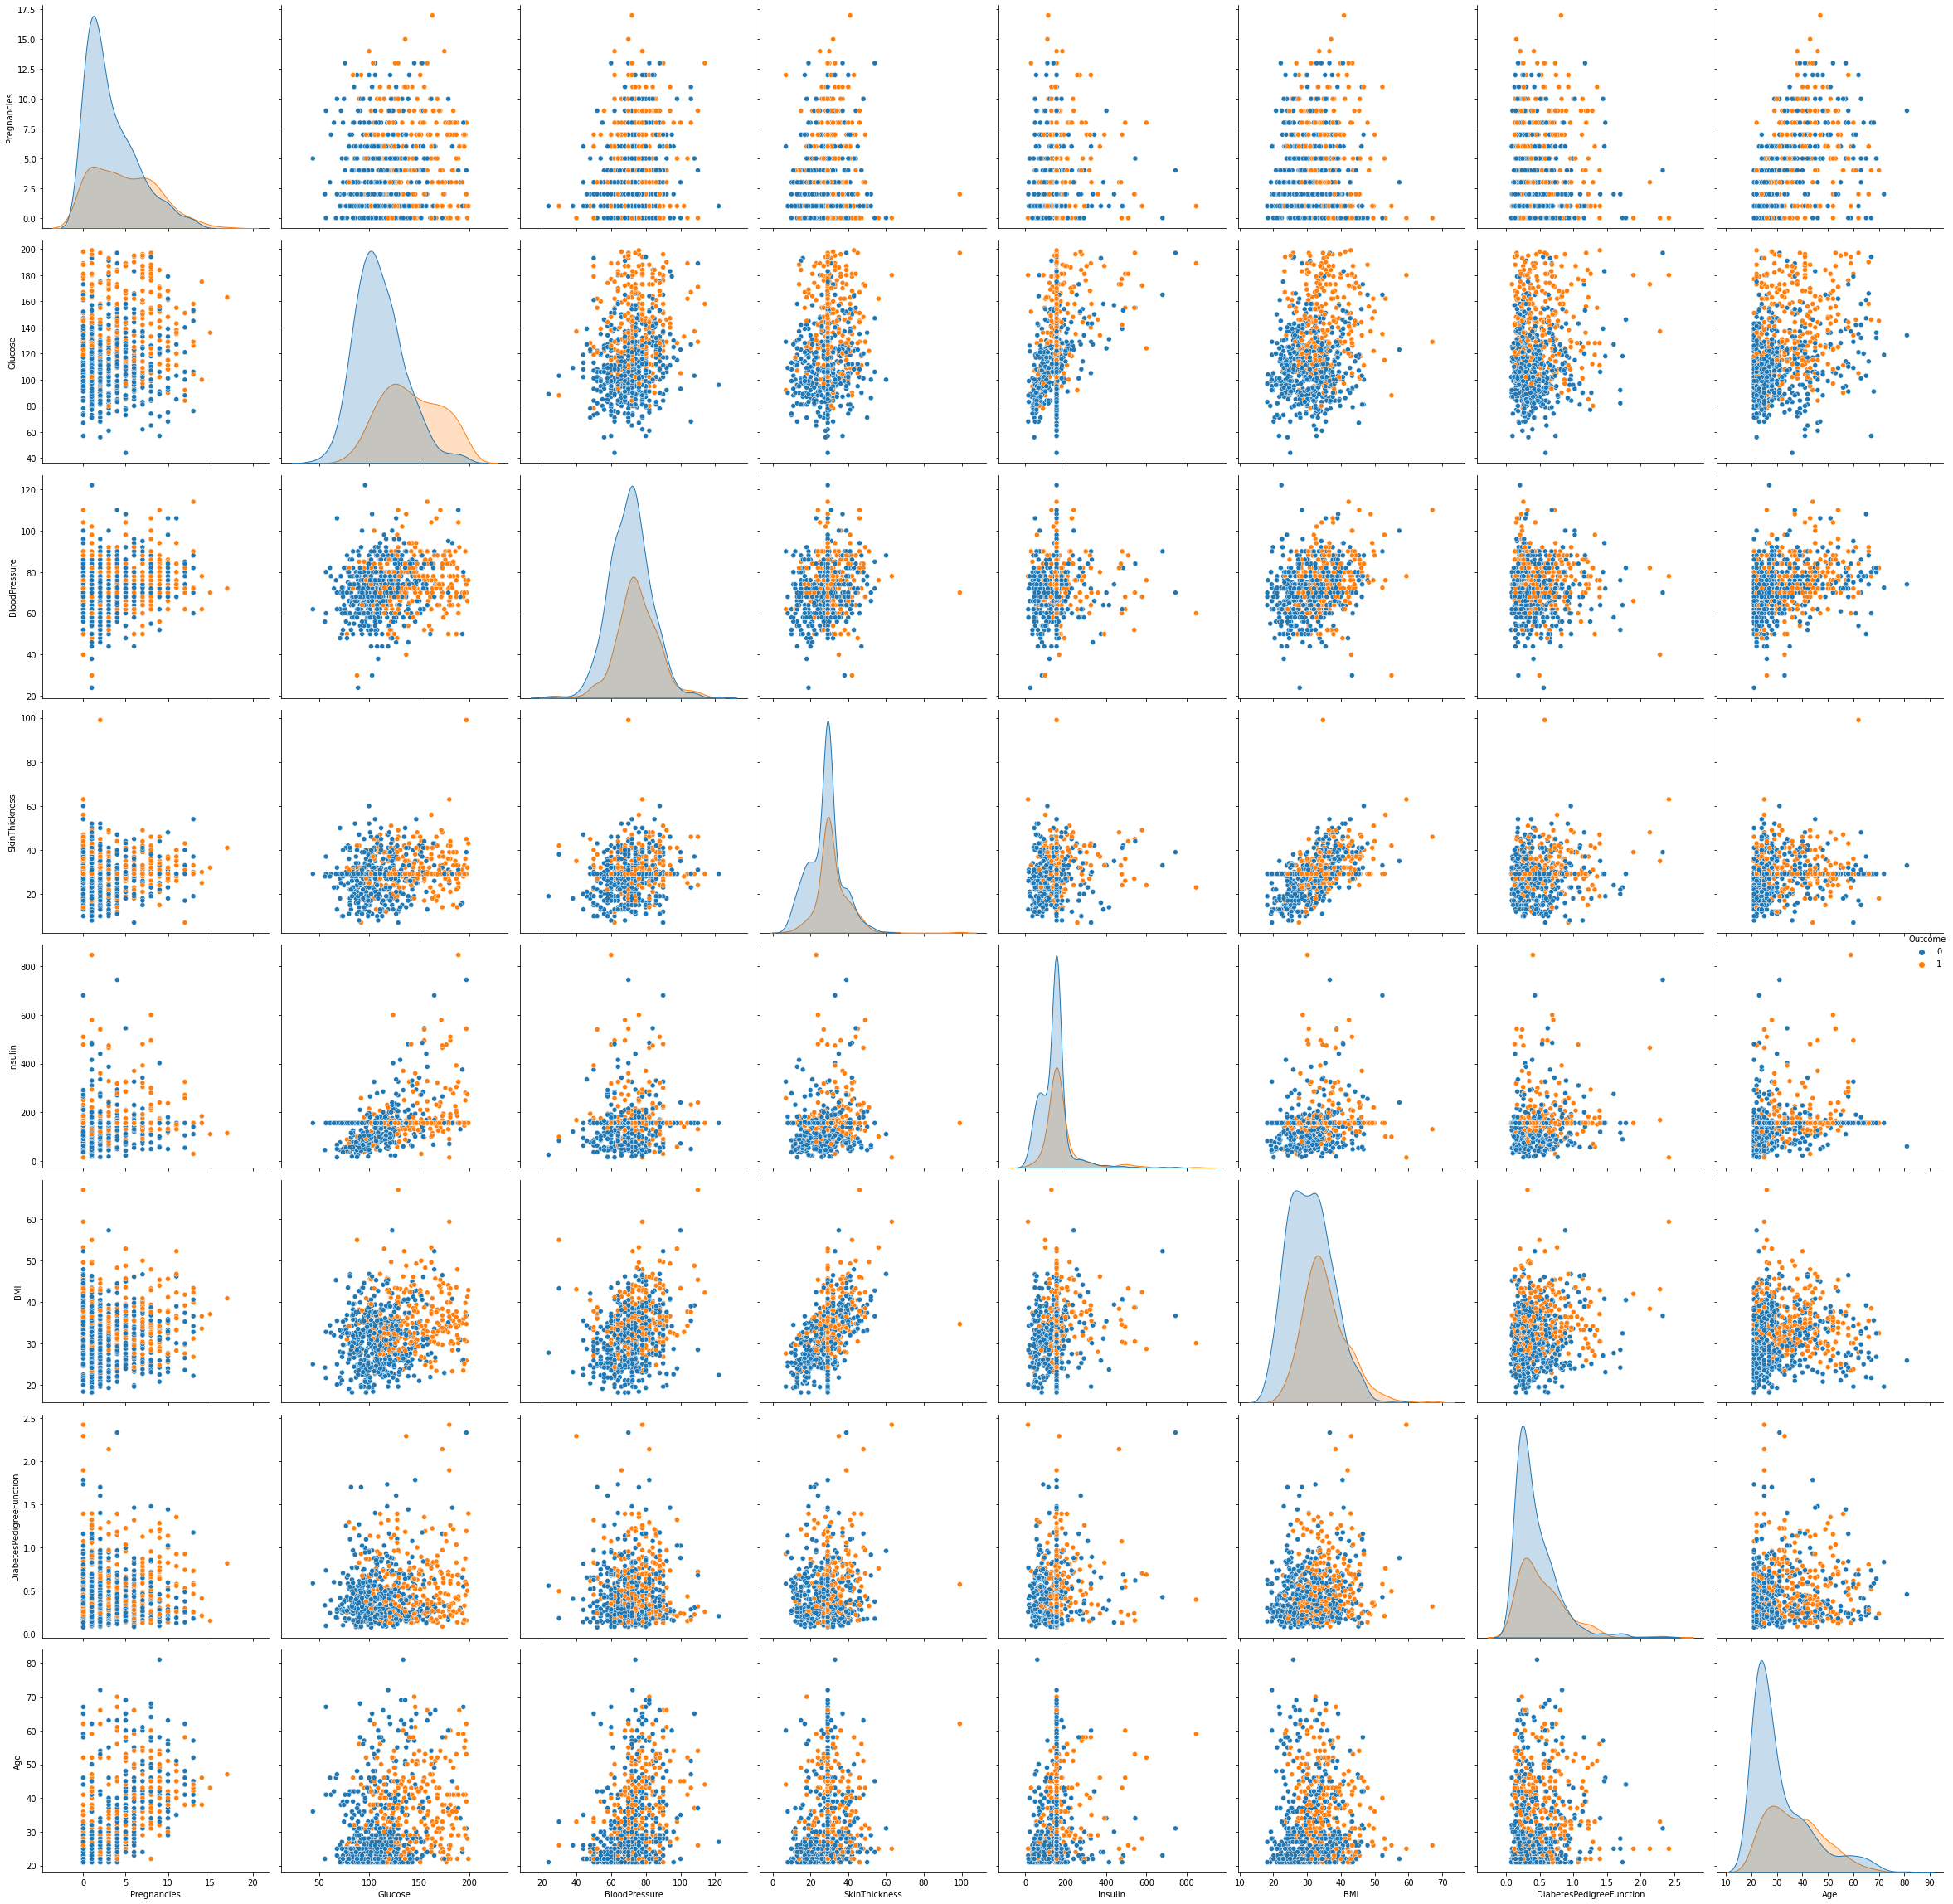

In [ ]:
# Generating a scatterplot matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=imp_diabetes_dataset, height=4.0, hue='Outcome')
plt.tight_layout()
plt.show()

As we see at the figure above, there is a slight relation between the features BMI and SkinThickness, which may suggest that we can select only one of these two for our model. At this point, we have too little information to make a feature selection, we don't even know yet whether our model is overfitting. Additionaly, we can assume that not a single feature separates the two outcome values in a big way. Let's create a **heatmap**, a square matrix that contains the **Pearson product-moment correlation coefficient**, which measure the linear dependence between pairs of features.

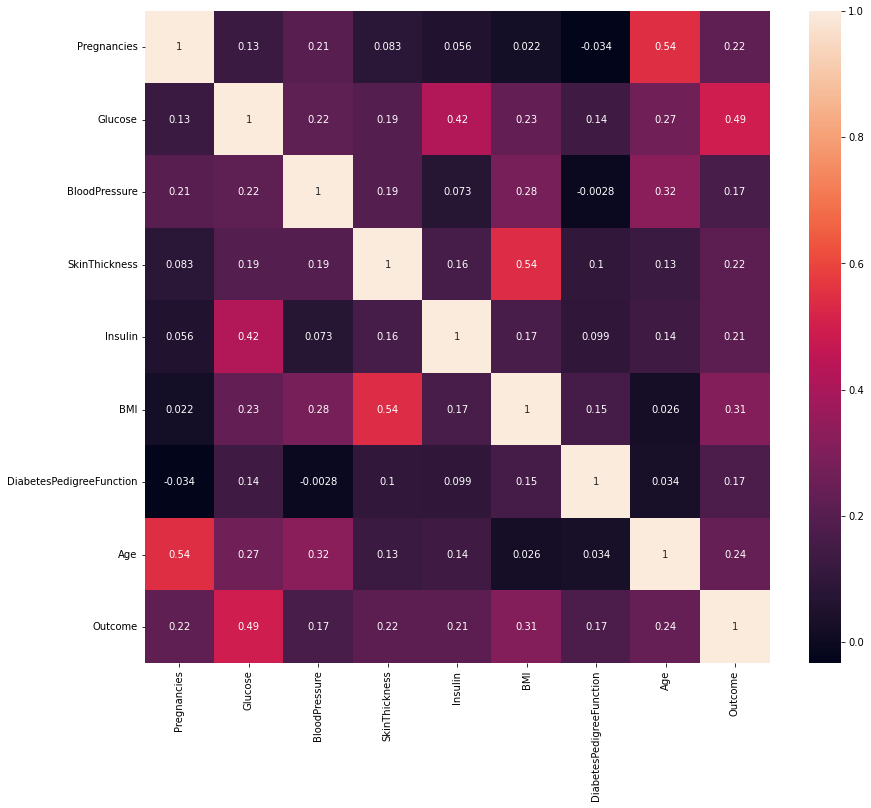

In [ ]:
#Generating a correlation heatmap
plt.figure(figsize=(14,12))
heatmap_diabetes=sns.heatmap(imp_diabetes_dataset.corr(), annot=True)

As can be seen, no two variables are clear correlated. Therefore, based on the information we have so far, we cannot eliminate any variable from our model.

### Splitting the data and stratifying

Let's randomly choose our training and test data using train_test_split function from scikit-learn's model_selection submodule. What is important, we want to **stratify** the 'Outcome' variable, so that we obtain the same proportions for all the classes in both the training and testing data.

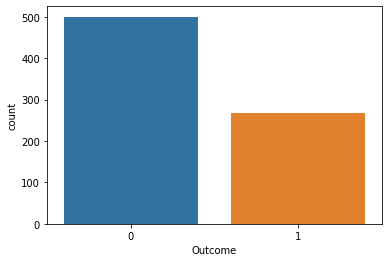

In [ ]:
sns.countplot(x='Outcome',data=imp_diabetes_dataset)
plt.show()

In [ ]:
# Splitting the data into training and test data simultaneously stratifying the 'Outcome'
from sklearn.model_selection import train_test_split
X, y = imp_diabetes_dataset.iloc[:, :-1].values, imp_diabetes_dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


### Feature scaling

In [ ]:
# Checking the variance of our variables
imp_diabetes_dataset.var()

Pregnancies                   11.354056
Glucose                      926.346983
BloodPressure                146.321591
SkinThickness                 77.280660
Insulin                     7228.588766
BMI                           47.267706
DiabetesPedigreeFunction       0.109779
Age                          138.303046
Outcome                        0.227483
dtype: float64

Transformation of variables to a common scale is very often profitable. In addition to that, due to the very high variance (for example regarding 'Insulin'), we are obliged to **standardize the data**. This will result in centering the feature columns at mean 0 with standard deviation equal to 1.

In [ ]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = pd.DataFrame(sc.fit_transform(X_train), columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])
X_test_std = pd.DataFrame(sc.transform(X_test), columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [ ]:
X_train_std.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.253027,-0.035223,-1.726899,-0.005241,0.031181,0.501828,-1.047703,-0.700296
1,1.218171,1.766841,1.503251,0.539136,1.875455,0.169254,-0.025033,2.134750
2,-0.841506,-0.330106,0.653212,1.774677,-0.269469,0.328311,-0.776996,-0.786207
3,0.335452,-0.330106,-0.536843,-0.005241,0.031181,0.762104,-0.644651,0.674271
4,0.041213,-1.280285,1.163235,-1.145692,0.031181,-0.466975,-0.476211,0.072898


## Building our model

We will apply the **grid search method to perform hyper-parameter optimisation using cross-validation**. We are going to additionaly divide our training dataset into 5 parts. We reserve 1 part for testing and train the algorithm over the 4 parts.

We continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged to get a average accuracy of the algorithm. At the end we select the set of parameters that worked the best.


Based on the **cross-validation score** and the **ROC curve**, we will choose two classification methods that will perform best. After that by calculating **precision** (TP/TP+FP), **recall** (TP/TP+FN) and **f1 score** (2\*recall\*precision/recall+precision) values we are going to select one algorithm after which we will compute the final score - **accuracy** (from all the classes, how many of them we have predicted correctly) on our test dataset.

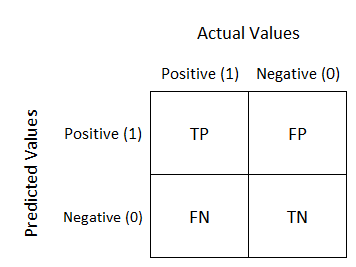

In [ ]:
cross_scores = []
algorithms=['KNN','Decision tree','Random forest','Logistic regression','SVM','XGBoost']

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_knn = {'n_neighbors': range(5,30)}
knn_grid = GridSearchCV(estimator=knn, param_grid=param_knn, scoring='f1', cv=5, n_jobs=-1)
knn_grid.fit(X_train_std, y_train)
cross_scores.append(knn_grid.best_score_)

print('Best parameters: ', knn_grid.best_params_)
print('Cross-validation f1 score: ', knn_grid.best_score_)

Best parameters:  {'n_neighbors': 11}
Cross-validation f1 score:  0.6486991497946091


The above result for KNN is as follows: we have obtained an average score, during cross-validation procedure, approximately equals 64.9% with the parameter n_neighbors equal to 11. We execute the same method for each algorithm we take into consideration in this project.

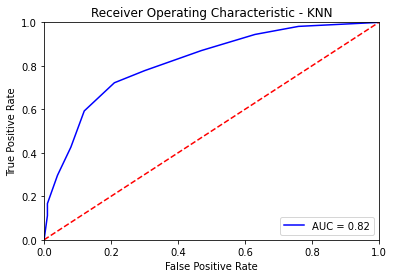

In [ ]:
#Generating ROC Curve for our KNN model
knn_y_score = knn_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, knn_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - KNN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
param_tree = {'max_depth': range(1,6), 'criterion': ['gini', 'entropy']}
tree_grid = GridSearchCV(estimator=tree, param_grid=param_tree, scoring='f1', cv=5, n_jobs=-1)
tree_grid.fit(X_train_std, y_train)
cross_scores.append(tree_grid.best_score_)

print('Best parameters: ', tree_grid.best_params_)
print('Cross-validation f1 score: ', tree_grid.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 4}
Cross-validation f1 score:  0.623097304885582


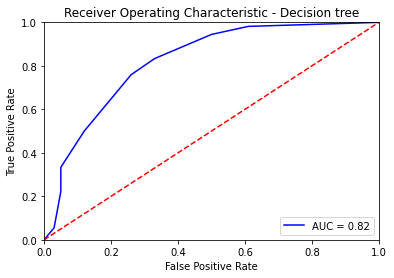

In [ ]:
#Generating ROC Curve for our Decision tree model
tree_y_score = tree_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, tree_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - Decision tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=1, n_jobs=-1)
param_forest = {'max_depth': range(1,4), 'n_estimators': [40, 50, 60],  'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}
forest_grid = GridSearchCV(estimator=forest, param_grid=param_forest, scoring='f1', cv=5, n_jobs=-1)
forest_grid.fit(X_train_std, y_train)
cross_scores.append(forest_grid.best_score_)

print('Best parameters: ', forest_grid.best_params_)
print('Cross-validation f1 score: ', forest_grid.best_score_)

Best parameters:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Cross-validation f1 score:  0.5738346623049139


In [ ]:
#Generating ROC Curve for our Random forest model
forest_y_score = forest_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, forest_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - Random forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')
param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(estimator=lr, param_grid=param_lr, scoring='f1', cv=5, n_jobs=-1)
lr_grid.fit(X_train_std, y_train)
cross_scores.append(lr_grid.best_score_)

print('Best parameters: ', lr_grid.best_params_)
print('Cross-validation f1 score: ', lr_grid.best_score_)

In [ ]:
#Generating ROC Curve for our Logistic regression model
lr_y_score = lr_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=1, probability=True)
param_svm = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
svm_grid = GridSearchCV(estimator=svm, param_grid=param_svm, scoring='f1', cv=5, n_jobs=-1)
svm_grid.fit(X_train_std, y_train)
cross_scores.append(svm_grid.best_score_)

print('Best parameters: ', svm_grid.best_params_)
print('Cross-validation f1 score: ', svm_grid.best_score_)

In [ ]:
svm_y_score = svm_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, svm_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGBoost

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier()
param_xgb = {'colsample_bytree':[0.5, 0.7, 0.9], 'max_depth':[2, 3, 4, 6], 'n_estimators': [30, 40, 50, 60], 'subsample': [0.6, 0.8, 1.0],  'gamma': [0.5, 1.5, 3, 5]}
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_xgb, scoring='f1', cv=5, n_jobs=-1)
xgb_grid.fit(X_train_std, y_train)
cross_scores.append(xgb_grid.best_score_)

print('Best parameters: ', xgb_grid.best_params_)
print('Cross-validation score: ', xgb_grid.best_score_)

In [ ]:
xgb_y_score = xgb_grid.predict_proba(X_test_std)[:, -1]
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_y_score)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Presenting the first results
results_cv=pd.DataFrame(cross_scores,index=algorithms)
results_cv.columns=['CV score']
results_cv

The highest cross-validation f1 score has XGBoost (66.3%), followed by KNN regression (64.9%). Analizing the Receiver Operator Characteristic (ROC) comes down to looking at how close the curve is to the upper left corner and calculating the area under the graph (AOC value). In general the closer the curve is to the corner and the bigger the AOC value, the better the performance of our classifier. In our case, KNN regression and XGBoost have the highest AOC value (0.82), so to the final comparison we choose **KNN regression** and **XGBoost**.

In [ ]:
knn_list = []
xgb_list = []
metrics=['precision','recall','f1 score']

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_std, y_train)
knn_predict = knn.predict(X_test_std)

print(classification_report(y_test,knn_predict))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0.5, max_depth=2, n_estimators=40, subsample=0.8)
xgb.fit(X_train_std, y_train)
xgb_predict = xgb.predict(X_test_std)

print(classification_report(y_test,xgb_predict))

The results clearly resolve which algorithm works best in our model. It is KNN regression 🥇.